In [22]:
import warnings
warnings.filterwarnings('ignore')
 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression 
from sklearn import svm,model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn import svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  f1_score, roc_curve, auc,plot_roc_curve,roc_auc_score

#### DATA

In [2]:
data = pd.read_csv("creditcard.csv")
print("Shape : ",data.shape)
data = data.drop_duplicates()
print("Shape w/o duplicates : ",data.shape)
X = data.drop("Class",axis=1)
y = data.Class

Shape :  (284807, 31)
Shape w/o duplicates :  (283726, 31)


In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=.2,random_state=123)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
print("Shapes :\nX_train ==> {}\nX_test  ==> {}\ny_train ==> {}\ny_test  ==> {}"
     .format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

Shapes :
X_train ==> (226980, 30)
X_test  ==> (56746, 30)
y_train ==> (226980,)
y_test  ==> (56746,)


In [6]:
print("Train :\n{}\n \nTest :\n{} ".format(y_train.value_counts(),y_test.value_counts()))

Train :
0    226602
1       378
Name: Class, dtype: int64
 
Test :
0    56651
1       95
Name: Class, dtype: int64 


### Manual class weights

In [7]:
weights = np.linspace(0.0,0.998,100)

### MODELS : 

#### 1 - Logistic Regression

In [60]:
lr = LogisticRegression()

In [1]:
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights],"C" : [1,10,100],"solver":["newton-cg", "lbfgs"]}

Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

In [85]:
f = open("lr_gridsearch_history.pkl","wb")
pickle.dump(gridsearch.cv_results_,f)
f.close()

In [62]:
gridsearch.best_estimator_

LogisticRegression(C=1,
                   class_weight={0: 0.1008080808080808, 1: 0.8991919191919192},
                   solver='newton-cg')

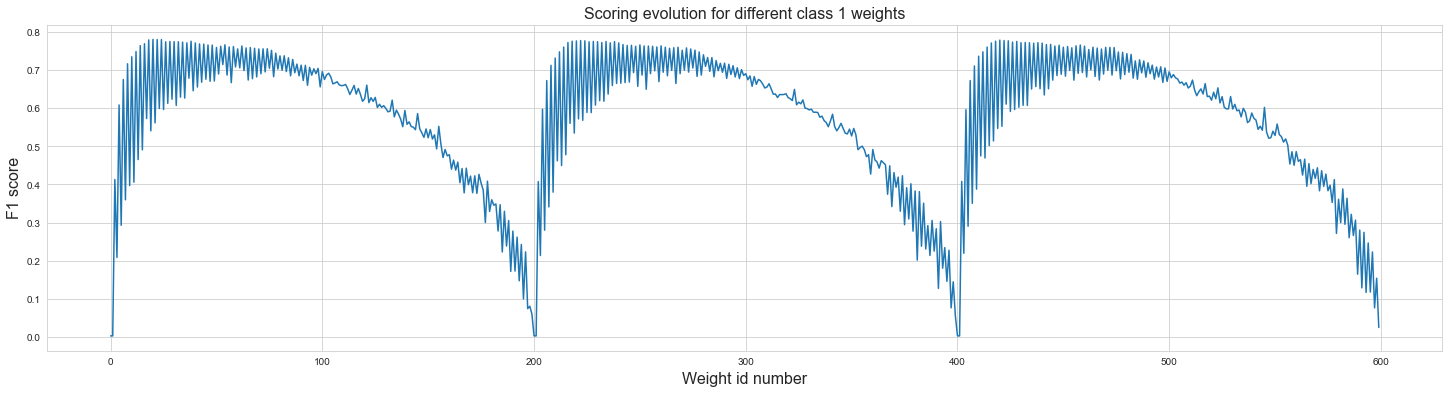

In [84]:
# Ploting the score for different values of weight
sns.set_style('whitegrid')

# All Weight values in : 
# gridsearch.cv_results_["param_class_weight"]

plt.figure(figsize=(25,6))
plt.plot(gridsearch.cv_results_['mean_test_score'])
plt.xlabel('Weight id number', fontsize=16)
plt.ylabel('F1 score', fontsize=16)
#plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring evolution for different class 1 weights', fontsize=16);

In [112]:
#lr_best = gridsearch.best_estimator_
lr_best.fit(X_train,y_train)
y_pred = lr_best.predict(X_test)

In [87]:
import pickle
filename = 'lr_model_fraude.pkl'
pickle.dump(lr_best, open(filename, 'wb'))

##### Performances LR :

The best model obtained by the gridsearch shows good score on test data

In [113]:
roc_auc_score(y_test,y_pred)

0.9051395943212782

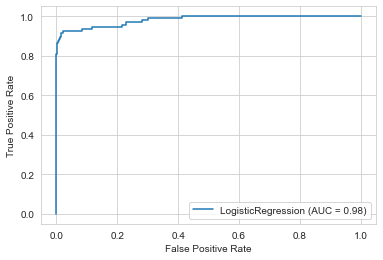

In [114]:
plot_roc_curve(lr_best,X_test,y_test);

In [89]:
pd.crosstab(y_test,y_pred)

col_0,0,1
Class,,
0,56638,13
1,18,77


Performances are not bat on the test set but the model still making mistakes at differentiating regular and fraudulent operations

In [90]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.86      0.81      0.83        95

    accuracy                           1.00     56746
   macro avg       0.93      0.91      0.92     56746
weighted avg       1.00      1.00      1.00     56746



The score for the under-represented class is obvously lower dans the regular class

#### 2 - Random Forest

In [95]:
rf = RandomForestClassifier()

Here we will only use weights as grid parameters because the training take too much time for many parameters.

In [2]:
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

gridsearch = GridSearchCV(estimator= rf, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

In [118]:
f = open("rf_gridsearch_history.pkl","wb")
pickle.dump(gridsearch.cv_results_,f)
f.close()

In [98]:
gridsearch.best_estimator_

RandomForestClassifier(class_weight={0: 0.29234343434343435,
                                     1: 0.7076565656565657})

In [99]:
rf_best = gridsearch.best_estimator_

In [103]:
rf_best.fit(X_train,y_train)

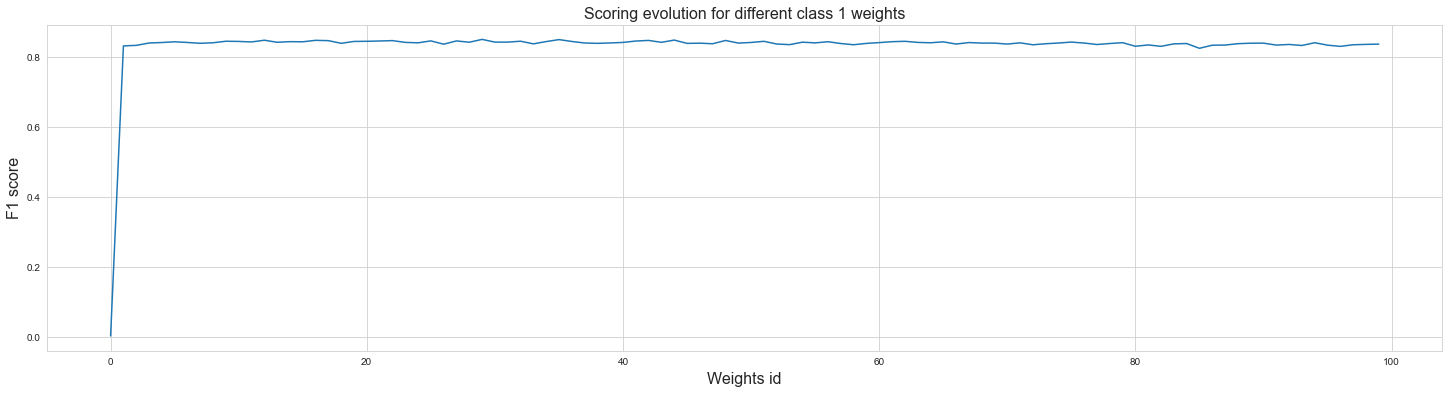

In [106]:
# Ploting the score for different values of weight
sns.set_style('whitegrid')

# All Weight values in : 
# gridsearch.cv_results_["param_class_weight"]

plt.figure(figsize=(25,6))
plt.plot(gridsearch.cv_results_['mean_test_score'])
plt.xlabel('Weights id', fontsize=16)
plt.ylabel('F1 score', fontsize=16)
#plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring evolution for different class 1 weights', fontsize=16);

In [117]:
import pickle
filename = 'rf_model_fraude.pkl'
pickle.dump(rf_best, open(filename, 'wb'))

#### Performances RF

The model shows almost the same performance in terms of score but there is a large difference on the confusion matrix

In [108]:
y_pred_rf = rf_best.predict(X_test)

In [109]:
roc_auc_score(y_test,y_pred_rf)

0.8947103641966648

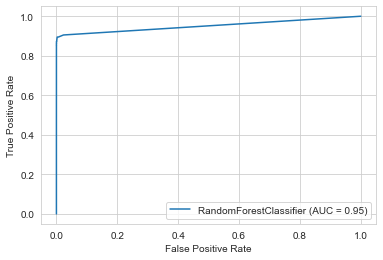

In [110]:
plot_roc_curve(rf_best,X_test,y_test);

In [115]:
pd.crosstab(y_test,y_pred_rf)

col_0,0,1
Class,,
0,56648,3
1,20,75


We can say with pretension that random forest model can quite well differ regular operations from fraudulent. Only three mistakes are made on the regular operations class. This model also make mistake on class 1 test data.

In [116]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.96      0.79      0.87        95

    accuracy                           1.00     56746
   macro avg       0.98      0.89      0.93     56746
weighted avg       1.00      1.00      1.00     56746



However, we can notice a raise of the class 1 f1-score

#### 3 - SVM

In [8]:
svm = svm.SVC()

In first place, we will search for optimal weights in order to make variations on other parameters thereafter.
This first model should show same of worse performances than the first two.

In [3]:
##gamma because we use the rbf kernel
#param_grid_svm = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

gridsearch_svm = GridSearchCV(estimator= svm, 
                          param_grid= param_grid_svm,
                          cv=StratifiedKFold(n_splits=3), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

In [12]:
gridsearch_svm.best_estimator_

SVC(class_weight={0: 0.09072727272727273, 1: 0.9092727272727272})

In [14]:
import pickle
f = open("svm_gridsearch_history.pkl","wb")
pickle.dump(gridsearch_svm.cv_results_,f)
f.close()

In [15]:
svm_best = gridsearch_svm.best_estimator_

In [16]:
svm_best.fit(X_train,y_train)
y_pred_svm = svm_best.predict(X_test)

In [17]:
import pickle
filename = 'svm_model_fraude.pkl'
pickle.dump(svm_best, open(filename, 'wb'))

In [18]:
roc_auc_score(y_test,y_pred_svm)

0.8630696350415145

In [19]:
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.87      0.73      0.79        95

    accuracy                           1.00     56746
   macro avg       0.94      0.86      0.90     56746
weighted avg       1.00      1.00      1.00     56746



In [20]:
pd.crosstab(y_test,y_pred_svm)

col_0,0,1
Class,,
0,56641,10
1,26,69


Now, we will vary the other parameters to get a better model

In [25]:
svm2 = svm.SVC(class_weight={0: 0.09072727272727273, 1: 0.9092727272727272})
param_grid_svm2 = {"kernel":["linear","poly","rbf"],"gamma":[0.001,0.01,1,10],"C":[0.001,0.01,1,10]}

In [26]:
gridsearch_svm2 = GridSearchCV(estimator= svm2, 
                          param_grid= param_grid_svm2,
                          cv=StratifiedKFold(n_splits=3), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 372.6min finished


In [27]:
gridsearch_svm2.best_estimator_

SVC(C=10, class_weight={0: 0.09072727272727273, 1: 0.9092727272727272},
    gamma=0.01, kernel='poly')

In [28]:
svm2_best = gridsearch_svm2.best_estimator_
svm2_best.fit(X_train,y_train)
y_pred_svm2 = svm2_best.predict(X_test)

In [29]:
print("roc auc score : ",roc_auc_score(y_test,y_pred_svm2),"\n")
print(classification_report(y_test,y_pred_svm2))

roc auc score :  0.9157453438365467 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.94      0.83      0.88        95

    accuracy                           1.00     56746
   macro avg       0.97      0.92      0.94     56746
weighted avg       1.00      1.00      1.00     56746



In [31]:
pd.crosstab(y_test,y_pred_svm2)

col_0,0,1
Class,,
0,56646,5
1,16,79


The best model of the three tested is the last SVM

In [32]:
filename = 'svmBest_model_fraude.pkl'
pickle.dump(svm2_best, open(filename, 'wb'))

In [33]:
f = open("svmBest_gridsearch_history.pkl","wb")
pickle.dump(gridsearch_svm2.cv_results_,f)
f.close()